# Analyzing PBMC scATAC-seq
This Jupyter notebook implements [this vignette](https://satijalab.org/signac/articles/pbmc_vignette.html).

In [1]:
setwd("..")
# set the plot sizes to be full width
library(repr)
# Change plot size to BIG
options(repr.plot.width=20, repr.plot.height=10)

In [2]:
raw = "data/test/atac_v1_pbmc_10k_filtered_peak_bc_matrix.h5"
metadata = "data/test/atac_v1_pbmc_10k_singlecell.csv"
fragments = "data/test/atac_v1_pbmc_10k_fragments.tsv.gz"

In [3]:
suppressMessages(library(Signac))
suppressMessages(library(Seurat))
suppressMessages(library(GenomeInfoDb))
suppressMessages(library(EnsDb.Hsapiens.v75))
suppressMessages(library(ggplot2))
suppressMessages(library(patchwork))

In [4]:
counts = Read10X_h5(filename = raw)
metadata = read.csv(
  file = metadata,
  header = TRUE,
  row.names = 1
)

In [5]:
pbmc = CreateSeuratObject(
  counts = counts,
  assay = 'peaks',
  project = 'ATAC',
  min.cells = 1,
  meta.data = metadata
)

Warning message in CreateSeuratObject.default(counts = counts, assay = "peaks", :
"Some cells in meta.data not present in provided counts matrix"


In [6]:
fragment.path = fragments

In [7]:
pbmc = SetFragments(
  object = pbmc,
  file = fragment.path
)

In [8]:
pbmc <- NucleosomeSignal(object = pbmc)

Extracting reads in requested region

Computing ratio of mononucleosomal to nucleosome-free fragments



Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message in self$trans$transform(x):
"NaNs produced"
Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message in self$trans$transform(x):
"NaNs produced"
Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Removed 259 rows containing non-finite values (stat_ydensity)."
Warning message:
"Removed 259 rows containing missing values (geom_point)."
Warning message:
"Removed 1 rows containing non-finite values (stat_ydensity)."


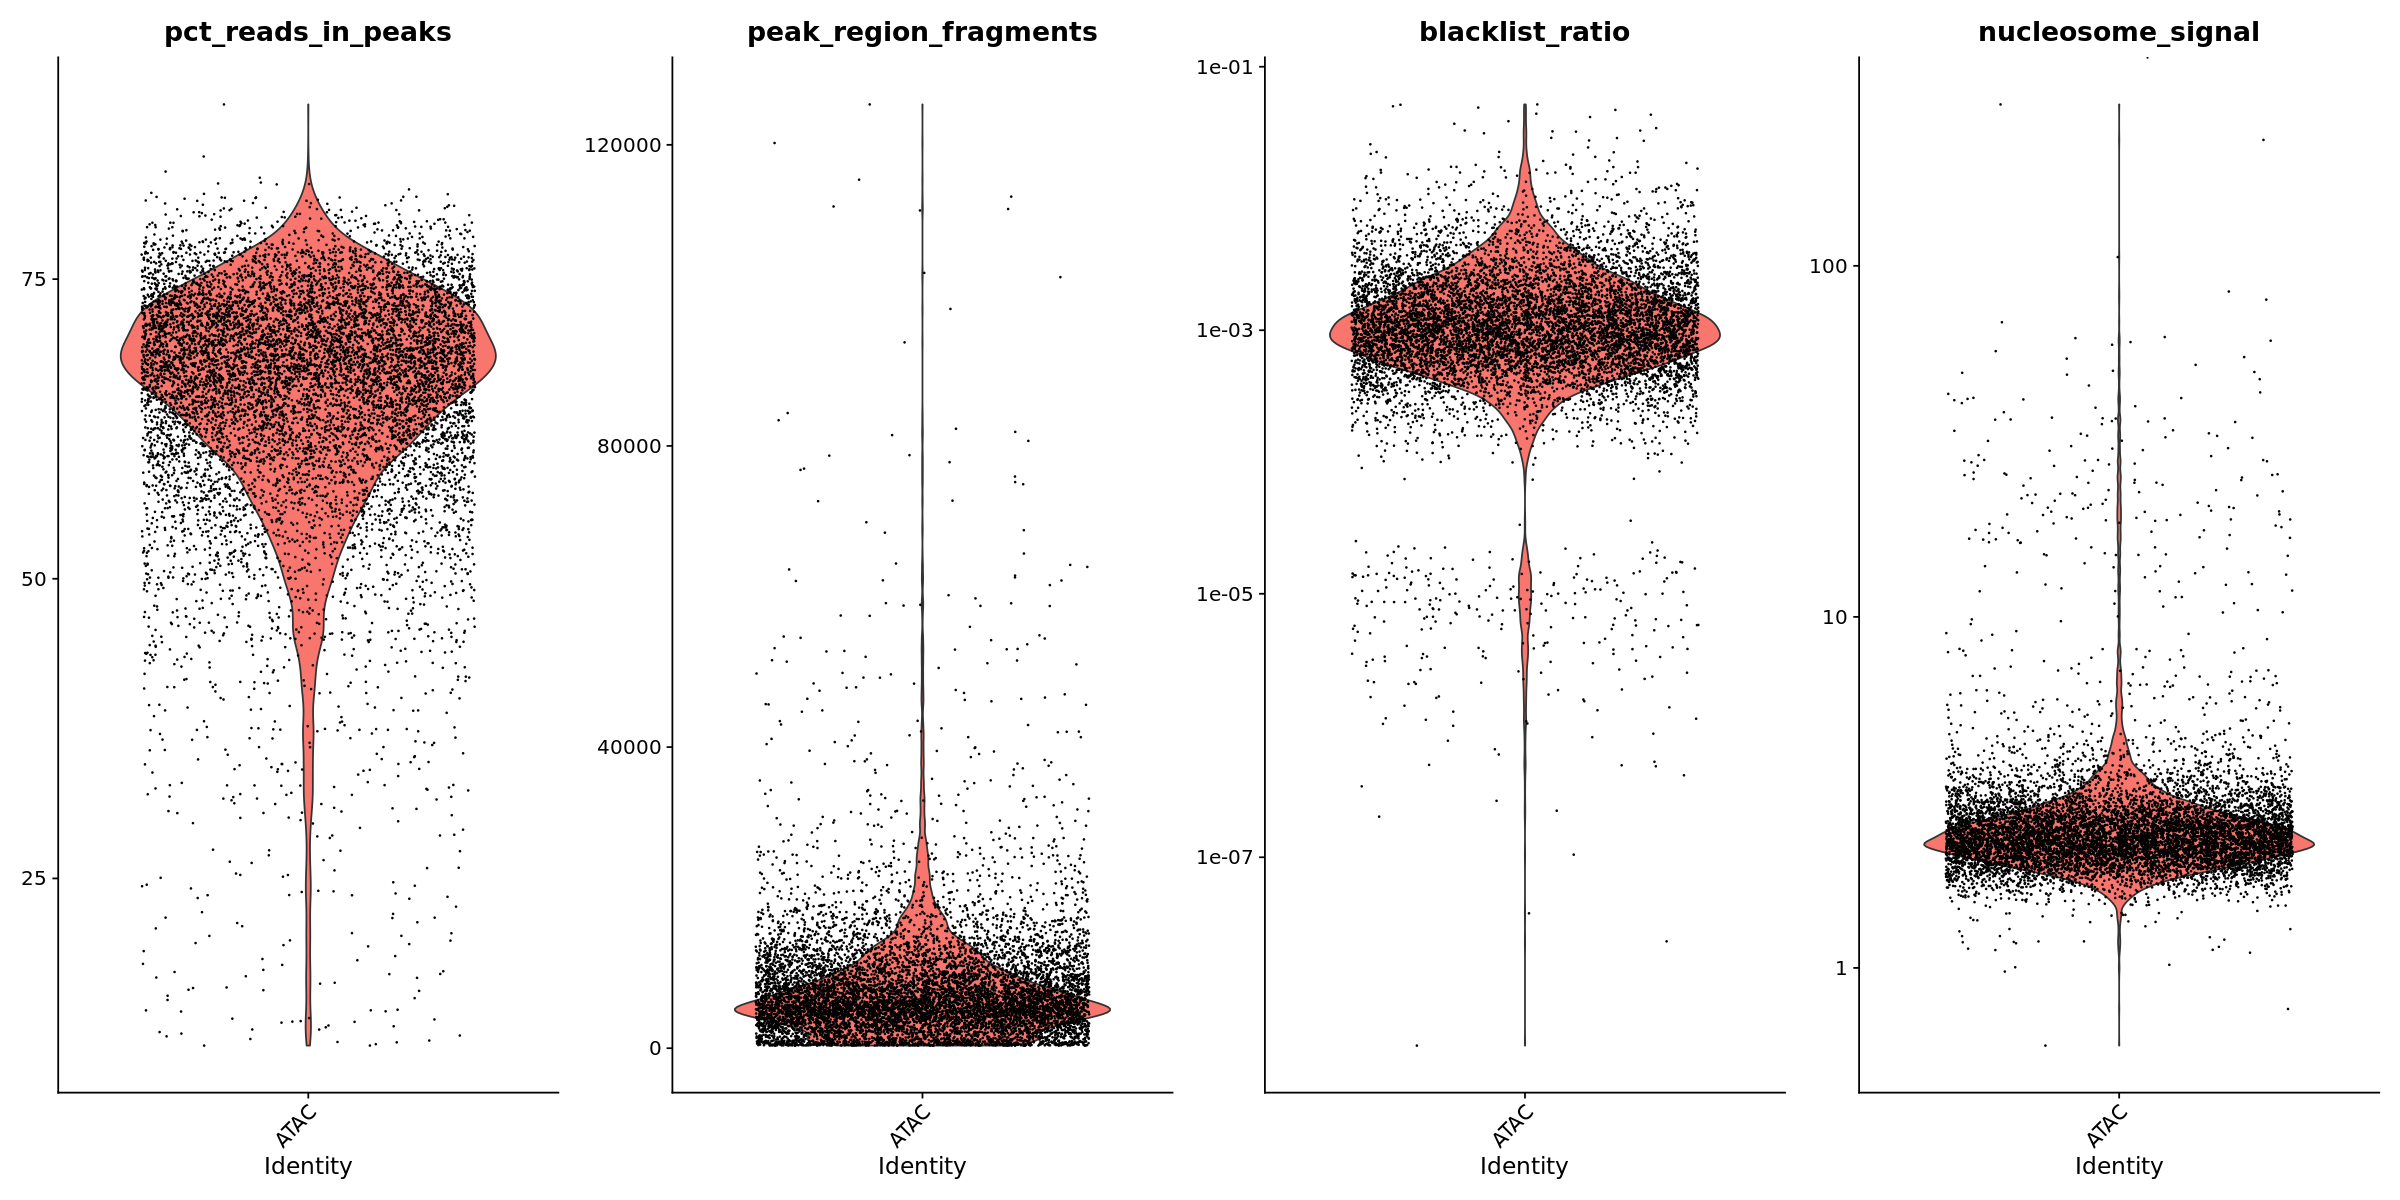

In [9]:
pbmc$pct_reads_in_peaks <- pbmc$peak_region_fragments / pbmc$passed_filters * 100
pbmc$blacklist_ratio <- pbmc$blacklist_region_fragments / pbmc$peak_region_fragments

p1 <- VlnPlot(pbmc, c('pct_reads_in_peaks', 'peak_region_fragments'), pt.size = 0.1)
p2 <- VlnPlot(pbmc, c('blacklist_ratio', 'nucleosome_signal'), pt.size = 0.1) & scale_y_log10()

p1 | p2

Warning message:
"Removed 91 rows containing non-finite values (stat_bin)."
Warning message:
"Removed 4 rows containing missing values (geom_bar)."


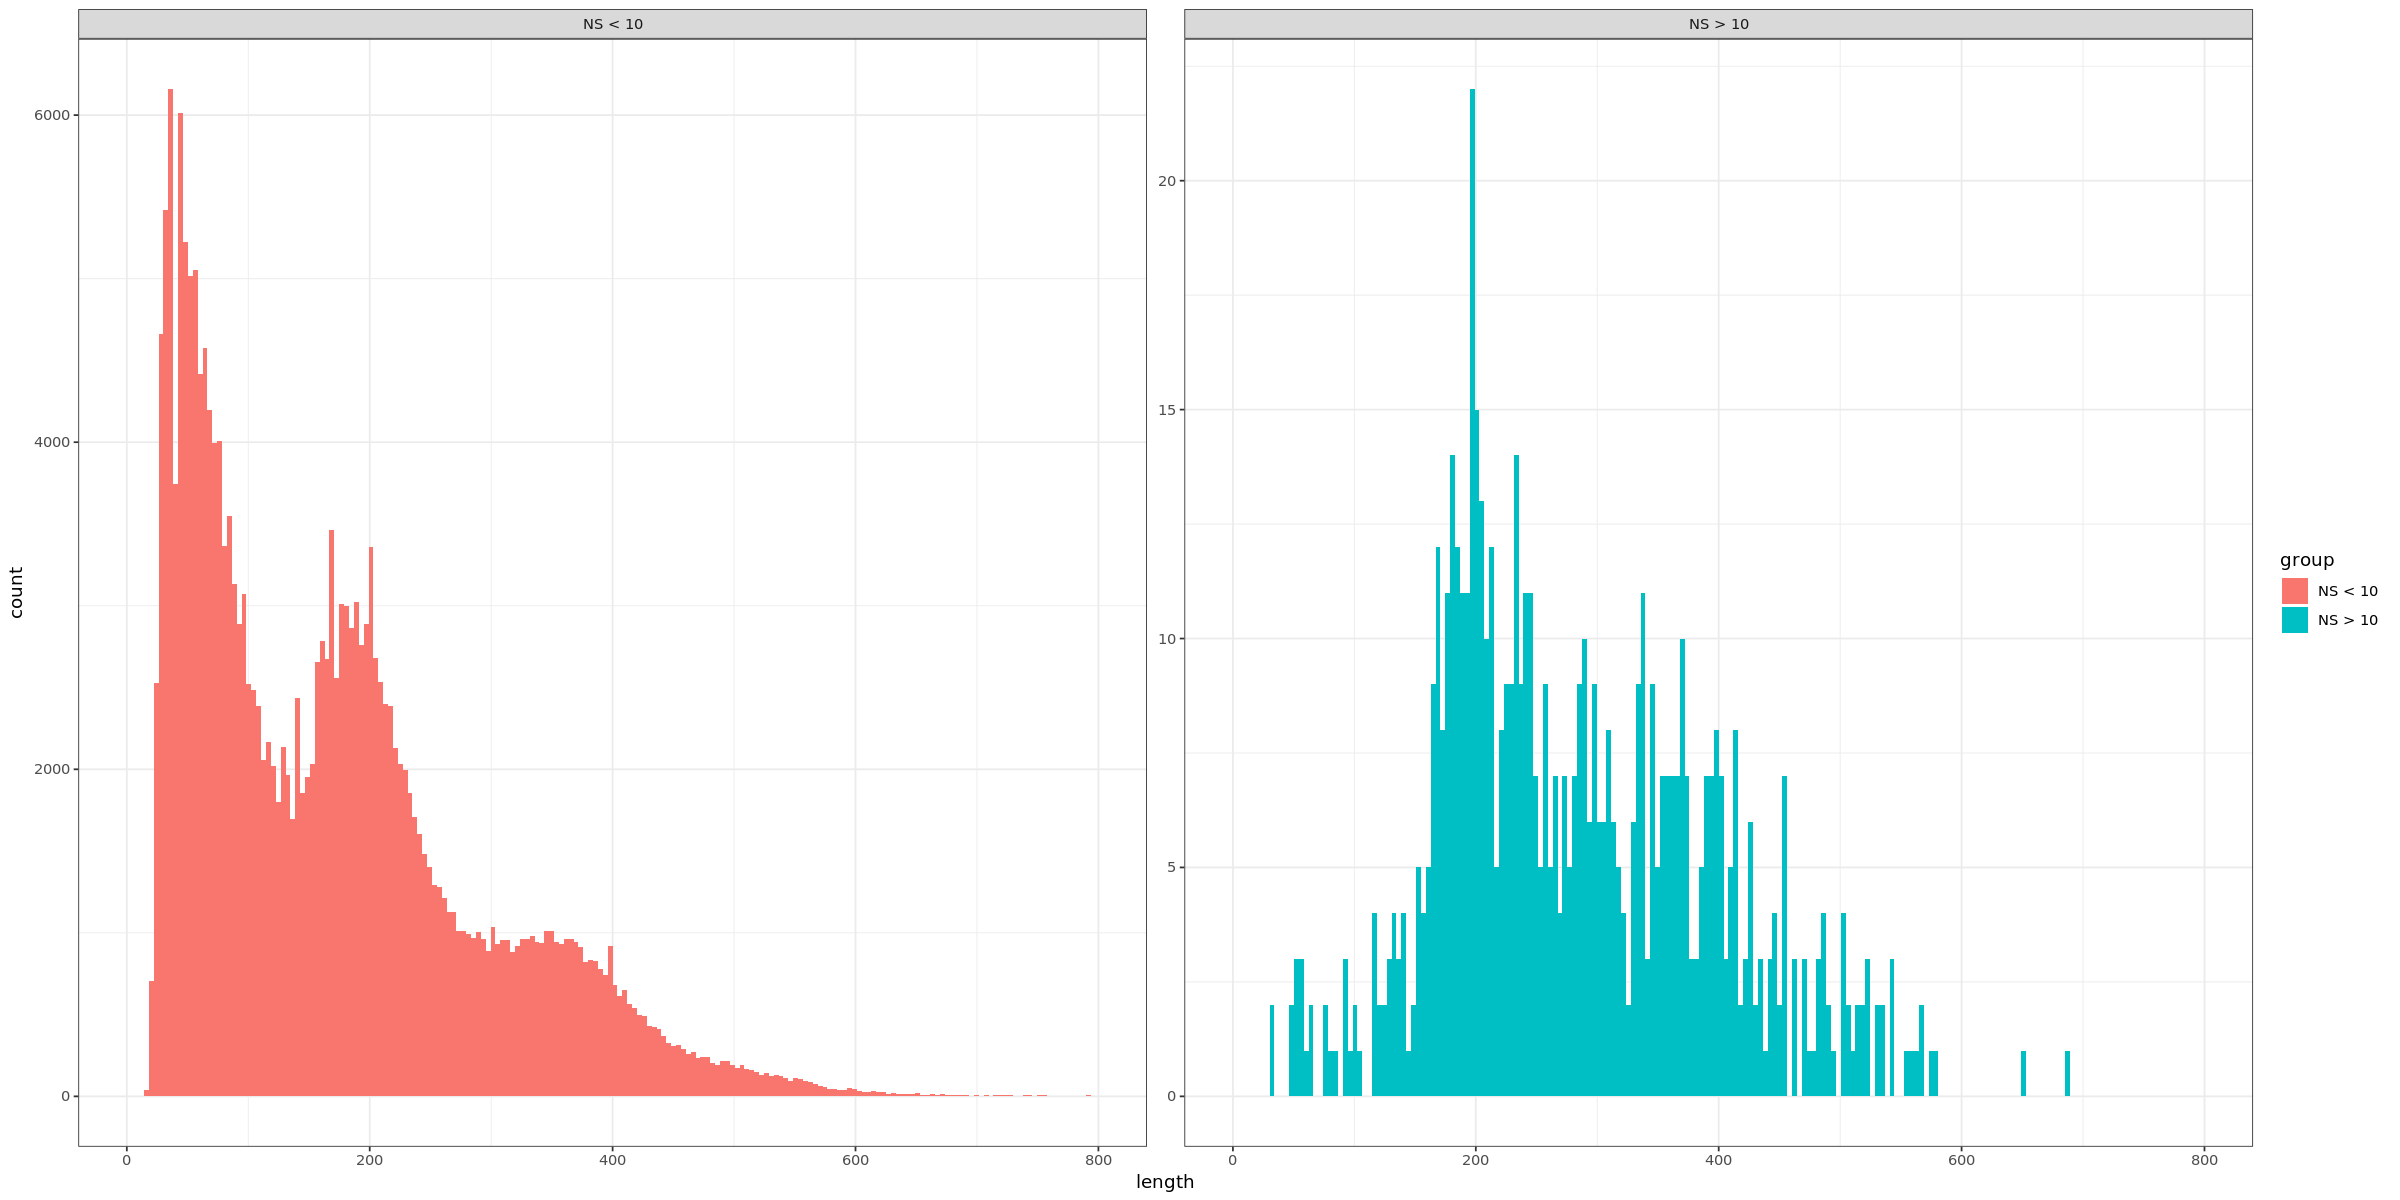

In [10]:
pbmc$nucleosome_group <- ifelse(pbmc$nucleosome_signal > 10, 'NS > 10', 'NS < 10')
FragmentHistogram(object = pbmc, group.by = 'nucleosome_group')

In [11]:
# create granges object with TSS positions
gene.ranges <- genes(EnsDb.Hsapiens.v75)
seqlevelsStyle(gene.ranges) <- 'UCSC'
gene.ranges <- gene.ranges[gene.ranges$gene_biotype == 'protein_coding', ]
gene.ranges <- keepStandardChromosomes(gene.ranges, pruning.mode = 'coarse')

tss.ranges <- resize(gene.ranges, width = 1, fix = "start")
seqlevelsStyle(tss.ranges) <- 'UCSC'
tss.ranges <- keepStandardChromosomes(tss.ranges, pruning.mode = 'coarse')

# to save time use the first 2000 TSSs
pbmc <- TSSEnrichment(object = pbmc, tss.positions = tss.ranges[1:2000])

Finding + strand cut sites

Finding - strand cut sites

Computing mean insertion frequency in flanking regions

Normalizing TSS score



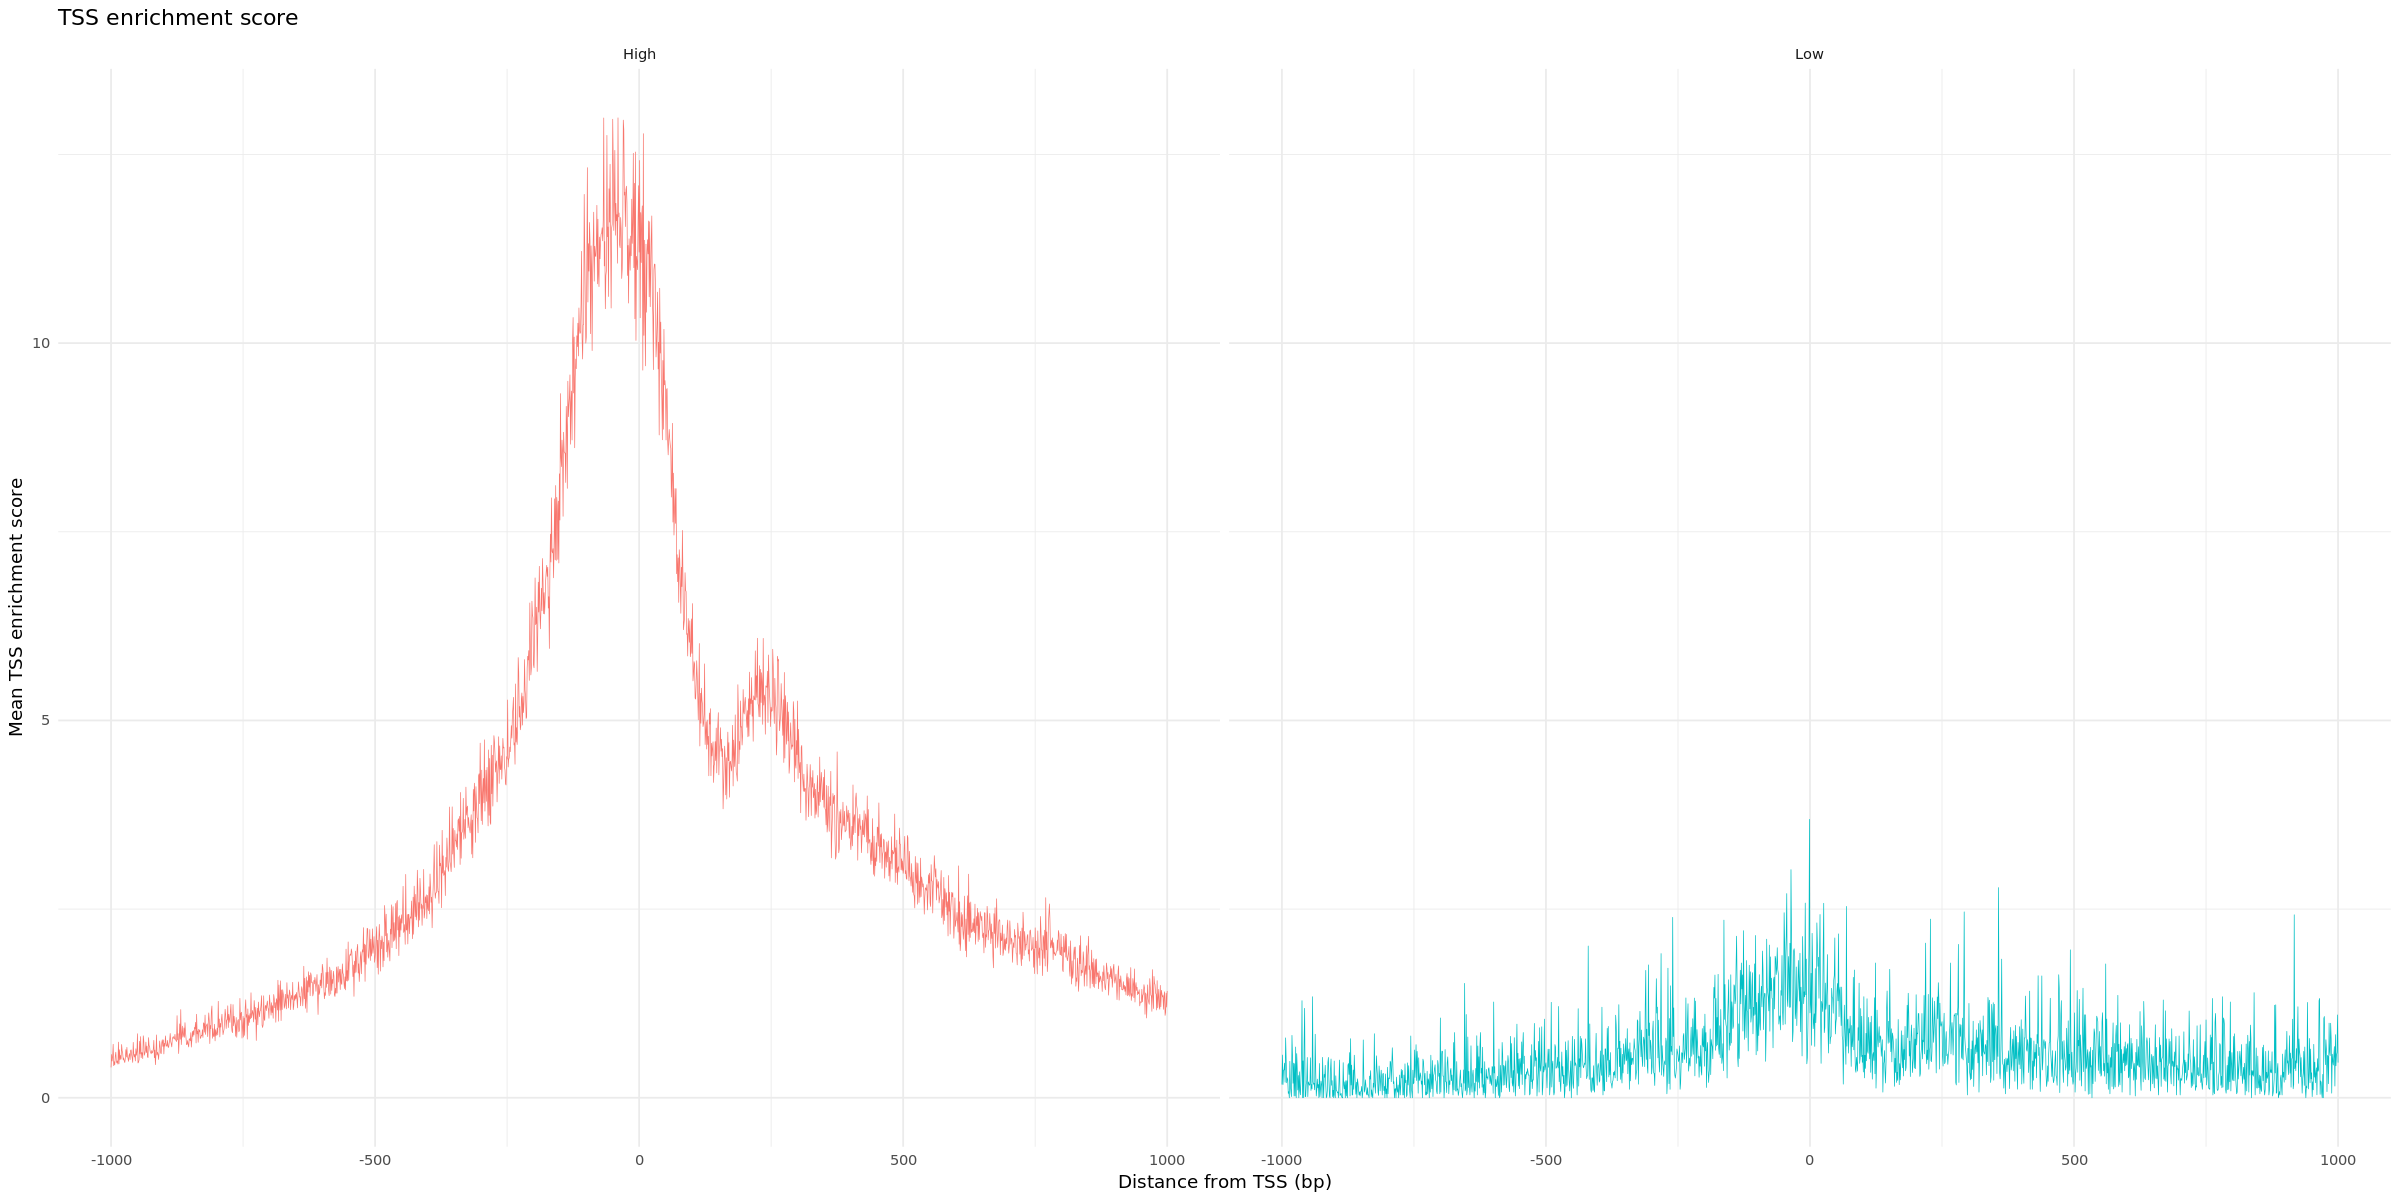

In [12]:
pbmc$high.tss <- ifelse(pbmc$TSS.enrichment > 2, 'High', 'Low')
TSSPlot(pbmc, group.by = 'high.tss') + ggtitle("TSS enrichment score") + NoLegend()

In [13]:
pbmc <- subset(
  x = pbmc,
  subset = peak_region_fragments > 3000 &
    peak_region_fragments < 20000 &
    pct_reads_in_peaks > 15 &
    blacklist_ratio < 0.05 &
    nucleosome_signal < 10 &
    TSS.enrichment > 2
)
pbmc

An object of class Seurat 
79921 features across 7029 samples within 1 assay 
Active assay: peaks (79921 features, 0 variable features)

In [14]:
pbmc <- RunTFIDF(pbmc)
pbmc <- FindTopFeatures(pbmc, min.cutoff = 'q0')
pbmc <- RunSVD(
  object = pbmc,
  assay = 'peaks',
  reduction.key = 'LSI_',
  reduction.name = 'lsi'
)

Performing TF-IDF normalization

Running SVD

Scaling cell embeddings



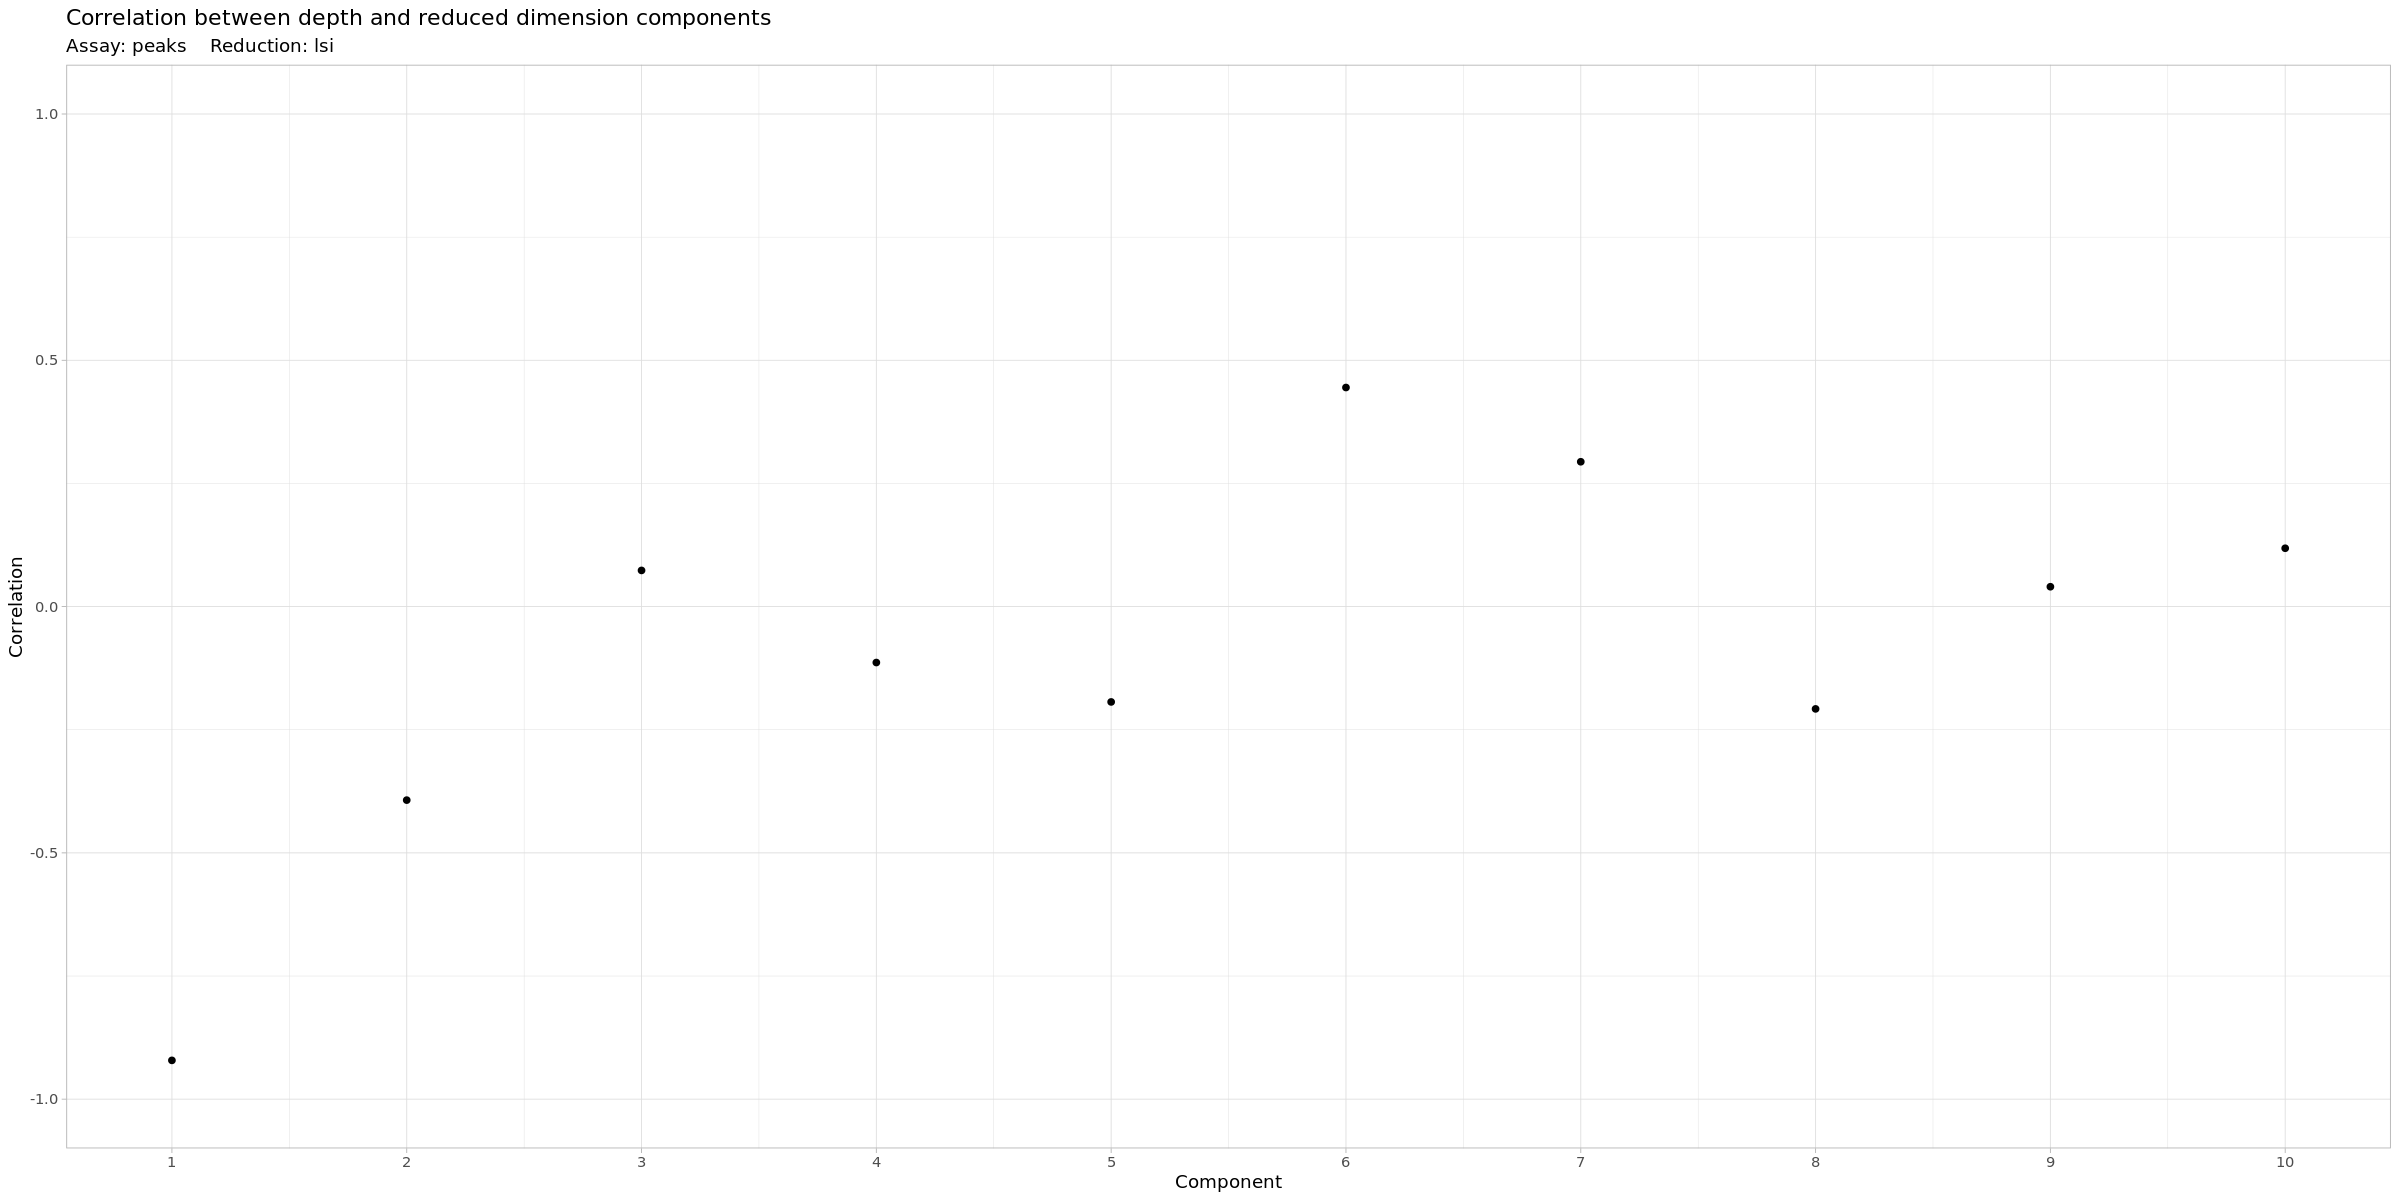

In [15]:
DepthCor(pbmc)

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
07:38:20 UMAP embedding parameters a = 0.9922 b = 1.112

07:38:20 Read 7029 rows and found 29 numeric columns

07:38:20 Using Annoy for neighbor search, n_neighbors = 30

07:38:20 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

07:38:21 Writing NN index file to temp file /tmp/RtmpTDPqBO/fileb9ed1ab5280a

07:38:21 Searching Annoy index using 1 thread, search_k = 3000

07:38:23 Annoy recall = 100%

07:38:25 Commencing smooth kNN distance calibration using 1 thread

07:38:28 Initializing fr

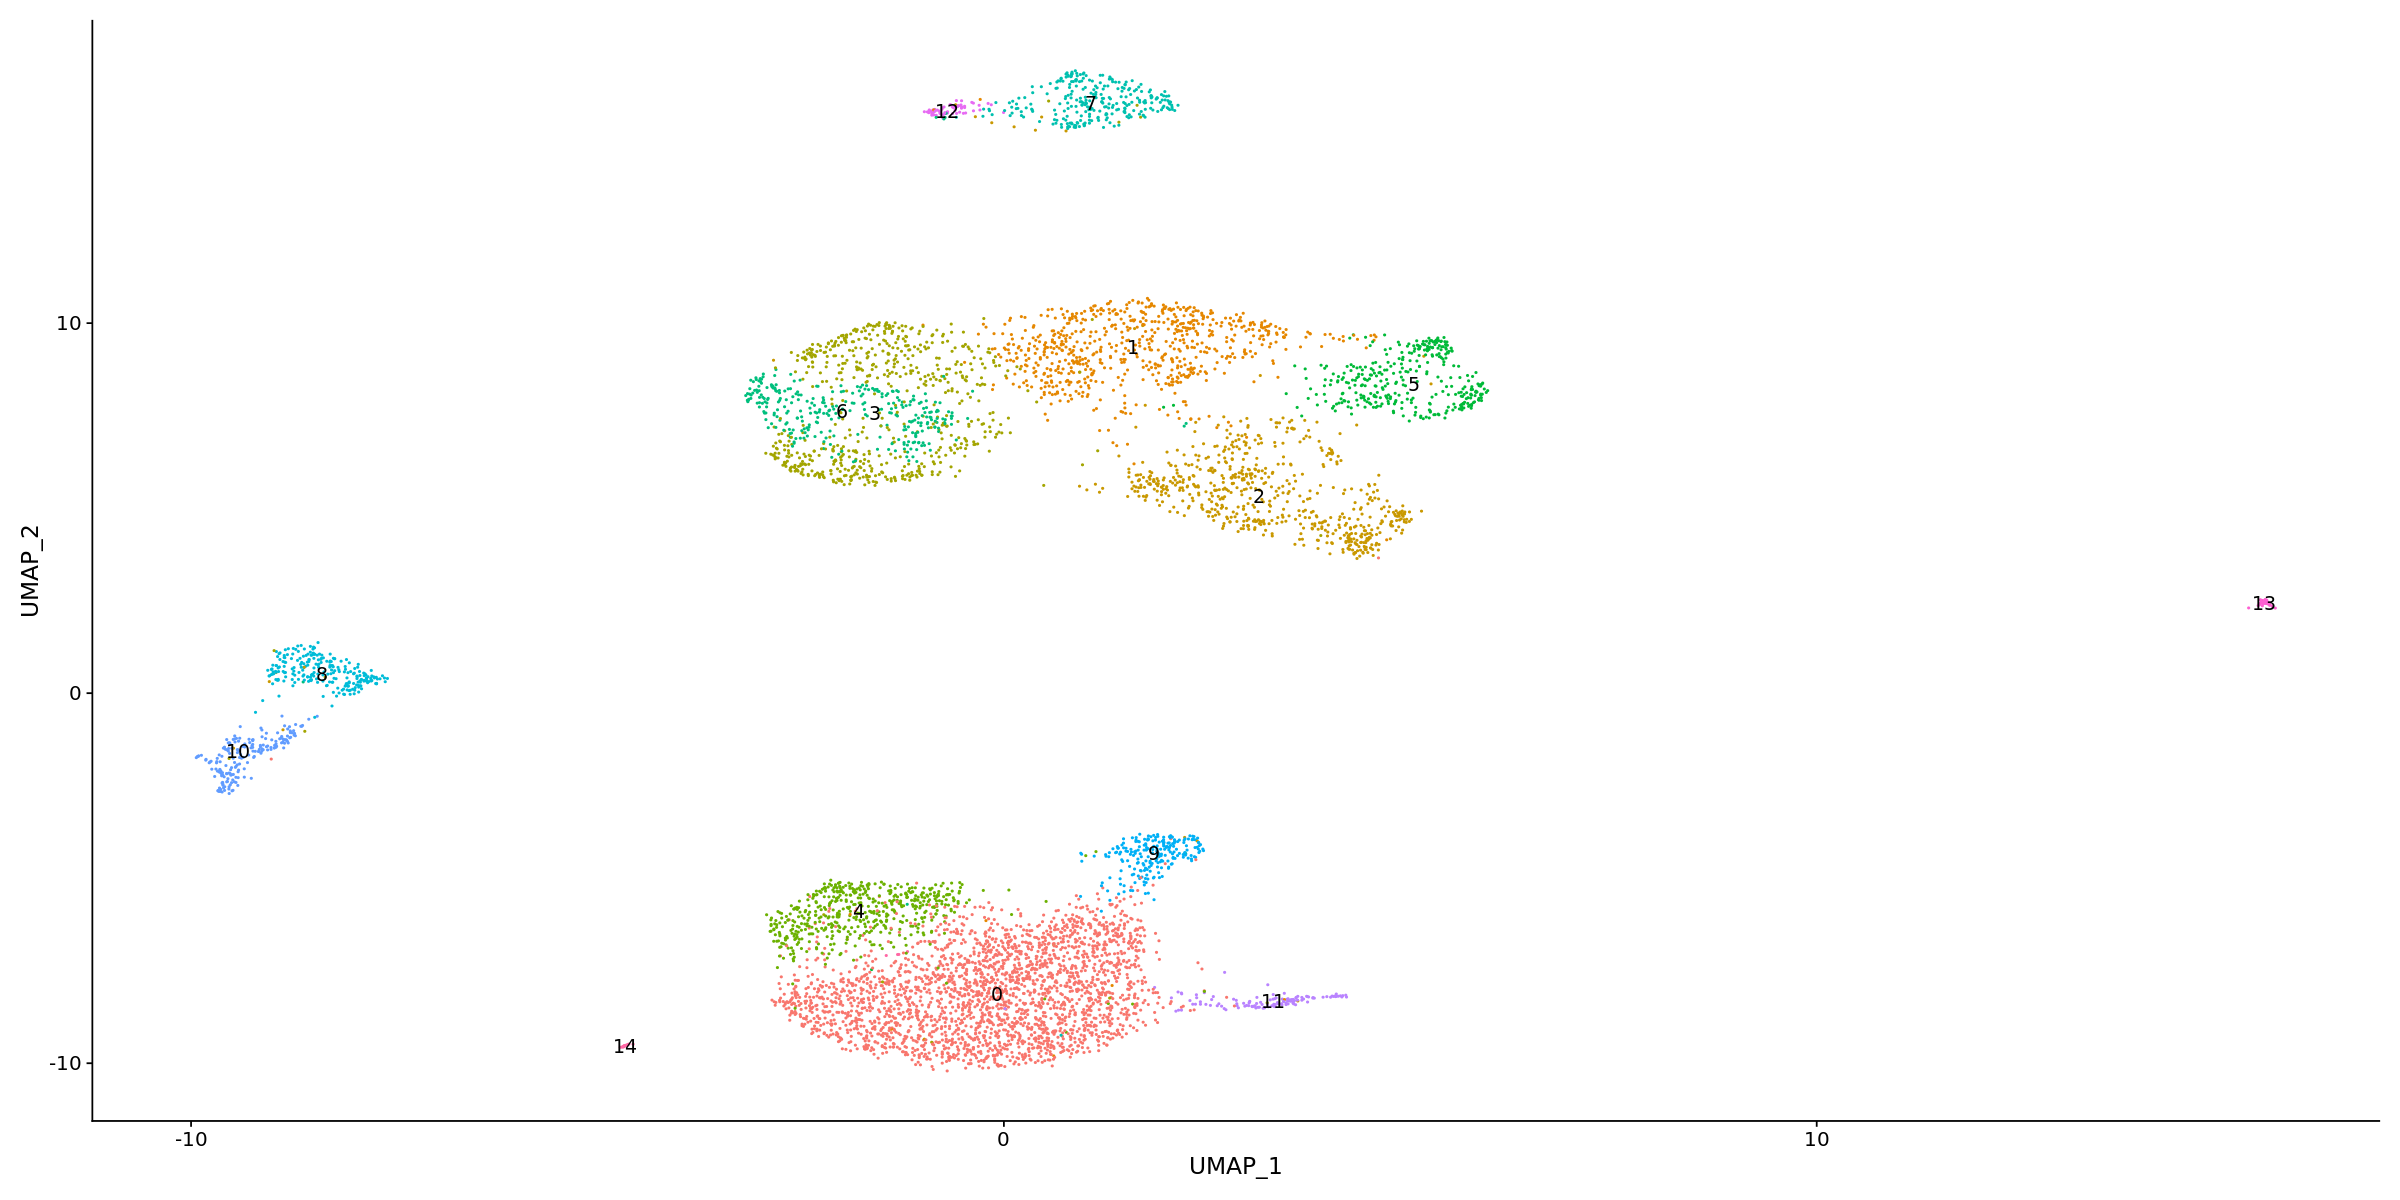

In [16]:
pbmc <- RunUMAP(object = pbmc, reduction = 'lsi', dims = 2:30)
pbmc <- FindNeighbors(object = pbmc, reduction = 'lsi', dims = 2:30)
pbmc <- FindClusters(object = pbmc, verbose = FALSE, algorithm = 3)
DimPlot(object = pbmc, label = TRUE) + NoLegend()